# DQN Trading System - Main Orchestration Notebook

This notebook orchestrates the complete DQN trading workflow:
1. Data collection and preprocessing (one-time per project)
2. Training for each strategy config
3. Out-of-sample validation comparison across all strategies
4. Final test comparison across all strategies

In [1]:
# Setup and imports
import sys
import os
import json
import glob
import warnings
warnings.filterwarnings('ignore')

# Import modules
from src.utils.config_loader import ConfigLoader
from src.utils.model_manager import ModelManager
from src.utils.progress_logger import ProgressLogger
from src.data.collector import DataCollector
from src.data.splitter import DataSplitter
from src.features.engineer import FeatureEngineer
from src.features.normalizer import RollingNormalizer
from src.trading.environment import TradingEnvironment
from src.training.trainer import DQNTrainer
from src.evaluation.validator import OutOfSampleValidator
from src.evaluation.metrics import PerformanceMetrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, HTML, clear_output
import time
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
%matplotlib inline

TensorFlow version: 2.12.0


## 1. Configuration

### Project Folder Structure:
- Each project folder contains:
  - `data_config.json` - Data settings, ticker, dates, validation/test splits
  - `trading_*.json` - One or more trading strategy configs

### Available Projects:
- `dry_run` - Quick test (1 episode, 2 years data)
- `default_run` - Full training (100 episodes, 10 years data)

### Test Mode:
- `test_mode=True` - Skip training if models exist, otherwise assert
- `test_mode=False` - Always perform training

In [2]:
# ========== CONFIGURATION ==========
PROJECT_FOLDER = 'my_project'  # Options: 'dry_run', 'default_run', or custom folder name
TEST_MODE = True  # If True, skip training if models exist (for testing only)
# ===================================

# Build paths
project_path = f'config/{PROJECT_FOLDER}'
data_config_path = f'{project_path}/data_config.json'

# Verify project folder exists
if not os.path.exists(project_path):
    raise ValueError(f"Project folder not found: {project_path}")

if not os.path.exists(data_config_path):
    raise ValueError(f"Data config not found: {data_config_path}")

# Load data config
data_config = ConfigLoader(data_config_path)

# Find all trading config files
trading_configs_paths = glob.glob(f'{project_path}/trading_*.json')
if not trading_configs_paths:
    raise ValueError(f"No trading configs found in {project_path}/")

# Sort for consistent ordering
trading_configs_paths.sort()

# Load all trading configs
trading_configs = []
for path in trading_configs_paths:
    with open(path, 'r') as f:
        tc = json.load(f)
        trading_configs.append({
            'path': path,
            'config': tc,
            'strategy_name': tc.get('strategy_name', tc.get('experiment_name', 'Unnamed')),
            'experiment_name': tc.get('experiment_name', os.path.basename(path).replace('.json', ''))
        })

# Initialize run
ticker = data_config.config['ticker']
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
run_name = f"{PROJECT_FOLDER}_{ticker}_{timestamp}"
logger = ProgressLogger(run_name=run_name, log_dir=f"logs/{PROJECT_FOLDER}")

# Create results directory early for saving plots
results_dir = f"results/{PROJECT_FOLDER}/run_{timestamp}"
os.makedirs(results_dir, exist_ok=True)

print(f"🚀 DQN Trading System")
print(f"{'='*70}")
print(f"📁 Project: {PROJECT_FOLDER}")
print(f"📊 Ticker: {ticker}")
print(f"📅 Date range: {data_config.config['start_date']} to {data_config.config['end_date']}")
print(f"🎯 Strategies: {len(trading_configs)}")
for i, tc in enumerate(trading_configs, 1):
    print(f"   {i}. {tc['strategy_name']} ({tc['experiment_name']})")
print(f"🧪 Test mode: {'ON' if TEST_MODE else 'OFF'}")
print(f"📝 Run name: {run_name}")
print(f"📂 Results will be saved to: {results_dir}")
print(f"{'='*70}")
print(f"\nMonitor this run: python monitor_training.py --run {run_name}")

[2026-01-21 06:56:00] Initialized - Run: my_project_SPY_20260121_065600
🚀 DQN Trading System
📁 Project: my_project
📊 Ticker: SPY
📅 Date range: 2005-01-01 to 2025-12-31
🎯 Strategies: 4
   1. SL/TP 10pct (Stop-Loss-Take-Profit-10pct)
   2. SL/TP 20pct (Stop-Loss-Take-Profit-20pct)
   3. No Guardrails (no_guardrails)
   4. No Guardrails (No BUY_MAX) (no_guardrails_no_buymax)
🧪 Test mode: ON
📝 Run name: my_project_SPY_20260121_065600
📂 Results will be saved to: results/my_project/run_20260121_065600

Monitor this run: python monitor_training.py --run my_project_SPY_20260121_065600


## 2. Data Collection (One-Time)

In [3]:
# Collect data once for all strategies
logger.start_stage("Data Collection", f"Collecting {ticker} and VIX data")

collector = DataCollector(data_config.config)
spy_data, vix_data = collector.collect_data(force_download=False)

info = collector.get_data_info(spy_data, vix_data)
logger.complete_stage("Data Collection", info)

print("✅ Data Collection Summary:")
for key, value in info.items():
    print(f"  {key}: {value}")

[2026-01-21 06:56:00] Starting: Data Collection - Collecting SPY and VIX data
  Found matching cache: SPY_20040426_20251230
Using cached data from data/SPY_20040426_20251230.csv
  Loaded 5456 records for SPY
  Found matching cache: VIX_20040426_20251230
Using cached data from data/VIX_20040426_20251230.csv
  Loaded 5456 records for ^VIX
[2026-01-21 06:56:00] Completed: Data Collection - Duration: 0.1s
✅ Data Collection Summary:
  SPY_records: 5456
  SPY_start: 2004-04-26
  SPY_end: 2025-12-30
  vix_records: 5456
  vix_start: 2004-04-26
  vix_end: 2025-12-30


## 3. Feature Engineering

In [4]:
# Combine data and create features
logger.start_stage("Feature Engineering", f"Creating technical indicators and features")

combined_data = collector.combine_data(spy_data, vix_data)
print(f"Combined data shape: {combined_data.shape}")

engineer = FeatureEngineer(data_config.config)
featured_data = engineer.create_features(combined_data)

feature_columns = engineer.get_feature_names(featured_data)
feature_info = engineer.get_feature_info(featured_data)

metrics = {
    'total_features': len(feature_columns),
    'price_features': len(feature_info['price_features']),
    'technical_indicators': len(feature_info['technical_indicators']),
    'volume_features': len(feature_info['volume_features']),
    'vix_features': len(feature_info['vix_features'])
}

logger.complete_stage("Feature Engineering", metrics)

print(f"\n✅ Total features: {len(feature_columns)}")
print(f"Feature categories:")
for category in ['price_features', 'technical_indicators', 'volume_features', 'vix_features']:
    print(f"  • {category}: {len(feature_info[category])} features")

[2026-01-21 06:56:00] Starting: Feature Engineering - Creating technical indicators and features
Combined data shape: (5456, 6)
Creating technical indicators...
Features created. Dropped 199 rows with NaN values.
Total features: 36
[2026-01-21 06:56:00] Completed: Feature Engineering - Duration: 0.1s

✅ Total features: 25
Feature categories:
  • price_features: 7 features
  • technical_indicators: 14 features
  • volume_features: 3 features
  • vix_features: 1 features


## 4. Data Splitting & Normalization

In [5]:
# Split data FIRST (before normalization to avoid lookahead bias)
logger.start_stage("Data Splitting", "Creating train/validation/test splits")

splitter = DataSplitter(data_config.config)
splits = splitter.split_data(featured_data, verbose=True)

train_data_raw = splits['train']
validation_periods_raw = splits['validation']
test_data_raw = splits['test']

print(f"\n✅ Data split complete (unnormalized):")
print(f"  • Training samples: {len(train_data_raw)}")
print(f"  • Validation periods: {len(validation_periods_raw)}")
print(f"  • Test samples: {len(test_data_raw)}")

# Continuous timeline normalization
print(f"\n📊 Normalizing data (continuous timeline, stateful rolling)...")
logger.start_stage("Data Normalization", "Applying continuous rolling Z-score normalization")

all_data_chronological = pd.concat([
    train_data_raw,
    *validation_periods_raw,
    test_data_raw
]).sort_index()

print(f"  • Chronological timeline: {len(all_data_chronological)} total samples")
print(f"  • Date range: {all_data_chronological.index.min().date()} to {all_data_chronological.index.max().date()}")

normalizer = RollingNormalizer(data_config.config)
all_data_normalized = normalizer.fit_transform(
    all_data_chronological,
    feature_columns,
    preserve_original=True
)

print(f"  ✓ Applied rolling normalization (window={data_config.config['data']['normalization_window']} days)")

# Extract normalized splits
train_data = all_data_normalized.loc[train_data_raw.index]
validation_periods = [
    all_data_normalized.loc[val_period.index]
    for val_period in validation_periods_raw
]
test_data = all_data_normalized.loc[test_data_raw.index]

logger.complete_stage("Data Normalization", {
    'train_shape': train_data.shape,
    'validation_periods': len(validation_periods),
    'test_shape': test_data.shape
})

logger.complete_stage("Data Splitting", {
    'training_samples': len(train_data),
    'validation_periods': len(validation_periods),
    'test_samples': len(test_data)
})

print(f"\n✅ Normalized data shapes:")
print(f"  • Train: {train_data.shape}")
print(f"  • Validation: {len(validation_periods)} periods")
print(f"  • Test: {test_data.shape}")

[2026-01-21 06:56:00] Starting: Data Splitting - Creating train/validation/test splits

DATA SPLIT SUMMARY

Training Data:
  - Records: 3,772
  - Date range: 2006-01-03 to 2024-12-27
  - Duration: 6933 days

Validation Data (5 years):
  Period 1:
    - Records: 227
    - Date range: 2005-02-08 to 2005-12-30
  Period 2:
    - Records: 253
    - Date range: 2008-01-02 to 2008-12-31
  Period 3:
    - Records: 250
    - Date range: 2012-01-03 to 2012-12-31
  Period 4:
    - Records: 252
    - Date range: 2013-01-02 to 2013-12-31
  Period 5:
    - Records: 252
    - Date range: 2021-01-04 to 2021-12-31

Test Data:
  - Records: 251
  - Date range: 2024-12-30 to 2025-12-30
  - Duration: 365 days

Total records: 5,257


✅ Data split complete (unnormalized):
  • Training samples: 3772
  • Validation periods: 5
  • Test samples: 251

📊 Normalizing data (continuous timeline, stateful rolling)...
[2026-01-21 06:56:00] Starting: Data Normalization - Applying continuous rolling Z-score normalization

## 5. Training Loop - All Strategies

Train a model for each trading config in the project folder.

In [6]:
# Storage for all results
all_results = {}
model_manager = ModelManager(base_dir="models")

for idx, tc_info in enumerate(trading_configs, 1):
    strategy_name = tc_info['strategy_name']
    experiment_name = tc_info['experiment_name']

    print(f"\n{'='*70}")
    print(f"📊 Strategy {idx}/{len(trading_configs)}: {strategy_name}")
    print(f"{'='*70}")

    # Merge data config with trading config and add project_folder for organized structure
    full_config = {
        **data_config.config,
        **tc_info['config'],
        'project_folder': PROJECT_FOLDER  # Add project folder for models/PROJECT_FOLDER/experiment_name structure
    }

    # Create training environment
    train_env = TradingEnvironment(
        train_data,
        feature_columns,
        full_config,
        mode='train'
    )

    # Model identifier will be auto-generated by trainer as: models/{project_folder}/{experiment_name}_...
    model_identifier = f"{PROJECT_FOLDER}/{experiment_name}"

    # Initialize trainer
    trainer = DQNTrainer(full_config, model_manager, progress_logger=logger)

    # Check for existing model (for TEST_MODE)
    # Directory format: {experiment_name}_{ticker}_{start_date}_{end_date}_ep{episodes}
    # Match using ticker to ensure exact experiment name match
    project_dir = f"models/{PROJECT_FOLDER}"
    existing_model_dirs = []
    if os.path.exists(project_dir):
        # Expected directory pattern with ticker
        dir_pattern = f"{experiment_name}_{ticker}_"
        for dir_name in os.listdir(project_dir):
            # Match: exact experiment name followed by _TICKER_
            # This prevents "no_guardrails" from matching "no_guardrails_no_buymax"
            if dir_name.startswith(dir_pattern):
                dir_path = os.path.join(project_dir, dir_name)
                if os.path.isdir(dir_path):
                    existing_model_dirs.append(dir_path)
    
    # Find model files in any matching directory
    existing_models = []
    for model_dir in existing_model_dirs:
        existing_models.extend(glob.glob(f"{model_dir}/*.h5"))

    # Training logic
    if TEST_MODE:
        if existing_models:
            # Find the latest model
            latest_model = sorted(existing_models)[-1]
            print(f"✅ Test mode: Loading existing model from {latest_model}")
            
            # Initialize the model architecture first (required before loading weights)
            dummy_state, _ = train_env.reset()
            state_shape = dummy_state.shape
            n_actions = train_env.action_masker.n_actions
            trainer.initialize_model(state_shape, n_actions)
            
            print(f"   Architecture: {n_actions} actions, state shape: {state_shape}")
            
            # Load the trained weights
            trainer.dqn.q_network.load_weights(latest_model)
            trainer.dqn.update_target_network()
            
            training_history = {'training_history': []}
            print(f"   Model loaded successfully")
        else:
            available_dirs = os.listdir(project_dir) if os.path.exists(project_dir) else []
            raise AssertionError(
                f"Test mode enabled but no models found for experiment '{experiment_name}'\n"
                f"   Searched in: {project_dir}/\n"
                f"   Looking for pattern: {experiment_name}_{ticker}_*\n"
                f"   Available directories: {available_dirs}"
            )
    else:
        # Train model
        logger.start_stage(f"Training: {strategy_name}",
                          f"Training for {full_config['training']['episodes']} episodes")

        print(f"Starting training...")
        print(f"📁 Models will be saved to: {project_dir}/{experiment_name}_{ticker}_*/")
        print(f"💾 Save frequency: Every {full_config['training']['save_frequency']} episodes")
        print(f"Monitor progress: python monitor_training.py --run {run_name}\n")

        # The trainer will automatically save models based on save_frequency
        training_history = trainer.train(train_env, validation_env=None, verbose=True)

        logger.complete_stage(f"Training: {strategy_name}", {
            'episodes_completed': len(training_history['training_history']),
            'final_return': training_history['training_history'][-1]['return'] if training_history['training_history'] else 0
        })

        print(f"\n✅ Training complete for {strategy_name}")

    # Store results
    all_results[strategy_name] = {
        'experiment_name': experiment_name,
        'trainer': trainer,
        'training_history': training_history,
        'config': full_config,
        'model_identifier': model_identifier
    }

print(f"\n{'='*70}")
print(f"✅ ALL TRAINING COMPLETE - {len(trading_configs)} strategies")
print(f"{'='*70}")


📊 Strategy 1/4: SL/TP 10pct
✅ Test mode: Loading existing model from models/my_project/Stop-Loss-Take-Profit-10pct_SPY_2005-01-01_2025-12-31_ep500/model_episode_500.h5
   Architecture: 10 actions, state shape: (5, 27)
   Model loaded successfully

📊 Strategy 2/4: SL/TP 20pct
✅ Test mode: Loading existing model from models/my_project/Stop-Loss-Take-Profit-20pct_SPY_2005-01-01_2025-12-31_ep500/model_episode_500.h5
   Architecture: 10 actions, state shape: (5, 27)
   Model loaded successfully

📊 Strategy 3/4: No Guardrails
✅ Test mode: Loading existing model from models/my_project/no_guardrails_SPY_2005-01-01_2025-12-31_ep500/model_episode_500.h5
   Architecture: 11 actions, state shape: (5, 27)
   Model loaded successfully

📊 Strategy 4/4: No Guardrails (No BUY_MAX)
✅ Test mode: Loading existing model from models/my_project/no_guardrails_no_buymax_SPY_2005-01-01_2025-12-31_ep500/model_episode_500.h5
   Architecture: 10 actions, state shape: (5, 27)
   Model loaded successfully

✅ ALL TR

In [7]:
# Plot training progress for all strategies
if not TEST_MODE:
    # Set professional plot style
    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 16,
        'axes.titlesize': 18,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'figure.titlesize': 20
    })
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 14))
    fig.patch.set_facecolor('white')

    for strategy_name, results in all_results.items():
        history = results['training_history']['training_history']
        if history:
            history_df = pd.DataFrame(history)

            # Row 1: Episode rewards, Total returns, Training Loss
            axes[0, 0].plot(history_df['episode'], history_df['reward'],
                          label=strategy_name, linewidth=2.5)
            axes[0, 0].set_title('Episode Rewards', fontsize=18, fontweight='bold')
            axes[0, 0].set_xlabel('Episode', fontsize=16)
            axes[0, 0].set_ylabel('Total Reward', fontsize=16)
            axes[0, 0].grid(True, alpha=0.3)

            axes[0, 1].plot(history_df['episode'], history_df['return'] * 100,
                          label=strategy_name, linewidth=2.5)
            axes[0, 1].set_title('Total Returns', fontsize=18, fontweight='bold')
            axes[0, 1].set_xlabel('Episode', fontsize=16)
            axes[0, 1].set_ylabel('Return (%)', fontsize=16)
            axes[0, 1].grid(True, alpha=0.3)

            axes[0, 2].plot(history_df['episode'], history_df.get('avg_loss', 0),
                          label=strategy_name, linewidth=2.5)
            axes[0, 2].set_title('Training Loss', fontsize=18, fontweight='bold')
            axes[0, 2].set_xlabel('Episode', fontsize=16)
            axes[0, 2].set_ylabel('Average Loss', fontsize=16)
            axes[0, 2].grid(True, alpha=0.3)

            # Row 2: Win rate, Number of trades, Sharpe Ratio
            axes[1, 0].plot(history_df['episode'], history_df['win_rate'] * 100,
                          label=strategy_name, linewidth=2.5)
            axes[1, 0].set_title('Win Rate', fontsize=18, fontweight='bold')
            axes[1, 0].set_xlabel('Episode', fontsize=16)
            axes[1, 0].set_ylabel('Win Rate (%)', fontsize=16)
            axes[1, 0].grid(True, alpha=0.3)

            axes[1, 1].plot(history_df['episode'], history_df['trades'],
                          label=strategy_name, linewidth=2.5)
            axes[1, 1].set_title('Number of Trades', fontsize=18, fontweight='bold')
            axes[1, 1].set_xlabel('Episode', fontsize=16)
            axes[1, 1].set_ylabel('Trades', fontsize=16)
            axes[1, 1].grid(True, alpha=0.3)

            axes[1, 2].plot(history_df['episode'], history_df['sharpe'],
                          label=strategy_name, linewidth=2.5)
            axes[1, 2].set_title('Sharpe Ratio', fontsize=18, fontweight='bold')
            axes[1, 2].set_xlabel('Episode', fontsize=16)
            axes[1, 2].set_ylabel('Sharpe', fontsize=16)
            axes[1, 2].grid(True, alpha=0.3)

            # Row 3: Sortino Ratio, Max Drawdown, Total Profit
            axes[2, 0].plot(history_df['episode'], history_df.get('sortino', history_df['sharpe']),
                          label=strategy_name, linewidth=2.5)
            axes[2, 0].set_title('Sortino Ratio', fontsize=18, fontweight='bold')
            axes[2, 0].set_xlabel('Episode', fontsize=16)
            axes[2, 0].set_ylabel('Sortino', fontsize=16)
            axes[2, 0].grid(True, alpha=0.3)

            axes[2, 1].plot(history_df['episode'], history_df['max_drawdown'] * 100,
                          label=strategy_name, linewidth=2.5)
            axes[2, 1].set_title('Max Drawdown', fontsize=18, fontweight='bold')
            axes[2, 1].set_xlabel('Episode', fontsize=16)
            axes[2, 1].set_ylabel('Drawdown (%)', fontsize=16)
            axes[2, 1].grid(True, alpha=0.3)

            axes[2, 2].plot(history_df['episode'], history_df['profit'],
                          label=strategy_name, linewidth=2.5)
            axes[2, 2].set_title('Total Profit', fontsize=18, fontweight='bold')
            axes[2, 2].set_xlabel('Episode', fontsize=16)
            axes[2, 2].set_ylabel('Profit ($)', fontsize=16)
            axes[2, 2].grid(True, alpha=0.3)

    # Single legend for entire figure
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.985), 
               ncol=len(all_results), fontsize=16, frameon=True, fancybox=True, shadow=True)

    plt.suptitle(f'Training Progress - {PROJECT_FOLDER}', fontsize=22, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save the plot
    plot_path = f"{results_dir}/training_progress.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"✅ Training progress plot saved to: {plot_path}")
    
    plt.show()
    
    # Reset to default
    plt.rcParams.update(plt.rcParamsDefault)
else:
    print("📊 Skipping training plots (TEST_MODE enabled)")

📊 Skipping training plots (TEST_MODE enabled)


## 6. Out-of-Sample Validation Comparison

Compare all strategies across all validation periods.

In [8]:
# Validate all strategies on all periods
print(f"\n{'='*70}")
print(f"📊 OUT-OF-SAMPLE VALIDATION COMPARISON")
print(f"{'='*70}")
print(f"Validation periods: {len(validation_periods)}\n")

validation_results = {}
validation_position_distributions = {}
metrics_calc = PerformanceMetrics()

for strategy_name, results in all_results.items():
    print(f"\nValidating: {strategy_name}")
    trainer = results['trainer']

    period_metrics = []
    position_sizes = []

    for i, val_period in enumerate(validation_periods, 1):
        print(f"  Period {i}: {val_period.index.min().date()} to {val_period.index.max().date()}", end=" ")

        val_env = TradingEnvironment(
            val_period,
            feature_columns,
            results['config'],
            mode='test'
        )

        val_metrics = trainer.evaluate(val_env, verbose=False)
        
        # Calculate comprehensive metrics including Sortino
        comprehensive_metrics = metrics_calc.calculate_metrics(
            val_env.portfolio_values,
            val_env.trades,
            val_env.starting_balance
        )
        
        # Collect position sizes from buy trades
        for trade in val_env.trades:
            if trade['action'] == 'BUY':
                position_sizes.append(trade['shares'])
        
        period_metrics.append({
            'period': i,
            'return': comprehensive_metrics.get('total_return', 0),
            'sharpe': comprehensive_metrics.get('sharpe_ratio', 0),
            'sortino': comprehensive_metrics.get('sortino_ratio', 0),
            'max_drawdown': comprehensive_metrics.get('max_drawdown', 0),
            'win_rate': comprehensive_metrics.get('win_rate', 0),
            'trades': comprehensive_metrics.get('num_trades', 0)
        })

        print(f"→ Return: {comprehensive_metrics.get('total_return', 0):.2%}")

    validation_results[strategy_name] = period_metrics
    validation_position_distributions[strategy_name] = position_sizes

print(f"\n✅ Validation complete for all strategies")


📊 OUT-OF-SAMPLE VALIDATION COMPARISON
Validation periods: 5


Validating: SL/TP 10pct
  Period 1: 2005-02-08 to 2005-12-30 → Return: 5.27%
  Period 2: 2008-01-02 to 2008-12-31 Guardrail Triggered at step 134: Stop Loss triggered (-10.29% loss)
Guardrail Triggered at step 187: Stop Loss triggered (-11.25% loss)
Guardrail Triggered at step 193: Stop Loss triggered (-10.52% loss)
Guardrail Triggered at step 207: Stop Loss triggered (-11.23% loss)
Guardrail Triggered at step 219: Stop Loss triggered (-10.02% loss)
Guardrail Triggered at step 225: Stop Loss triggered (-12.64% loss)
→ Return: -39.13%
  Period 3: 2012-01-03 to 2012-12-31 → Return: 11.70%
  Period 4: 2013-01-02 to 2013-12-31 → Return: 25.14%
  Period 5: 2021-01-04 to 2021-12-31 → Return: 22.82%

Validating: SL/TP 20pct
  Period 1: 2005-02-08 to 2005-12-30 → Return: 5.22%
  Period 2: 2008-01-02 to 2008-12-31 Guardrail Triggered at step 195: Stop Loss triggered (-23.20% loss)
→ Return: -33.58%
  Period 3: 2012-01-03 to 2012-12-

✅ Validation comparison plot saved to: results/my_project/run_20260121_065600/validation_comparison.png


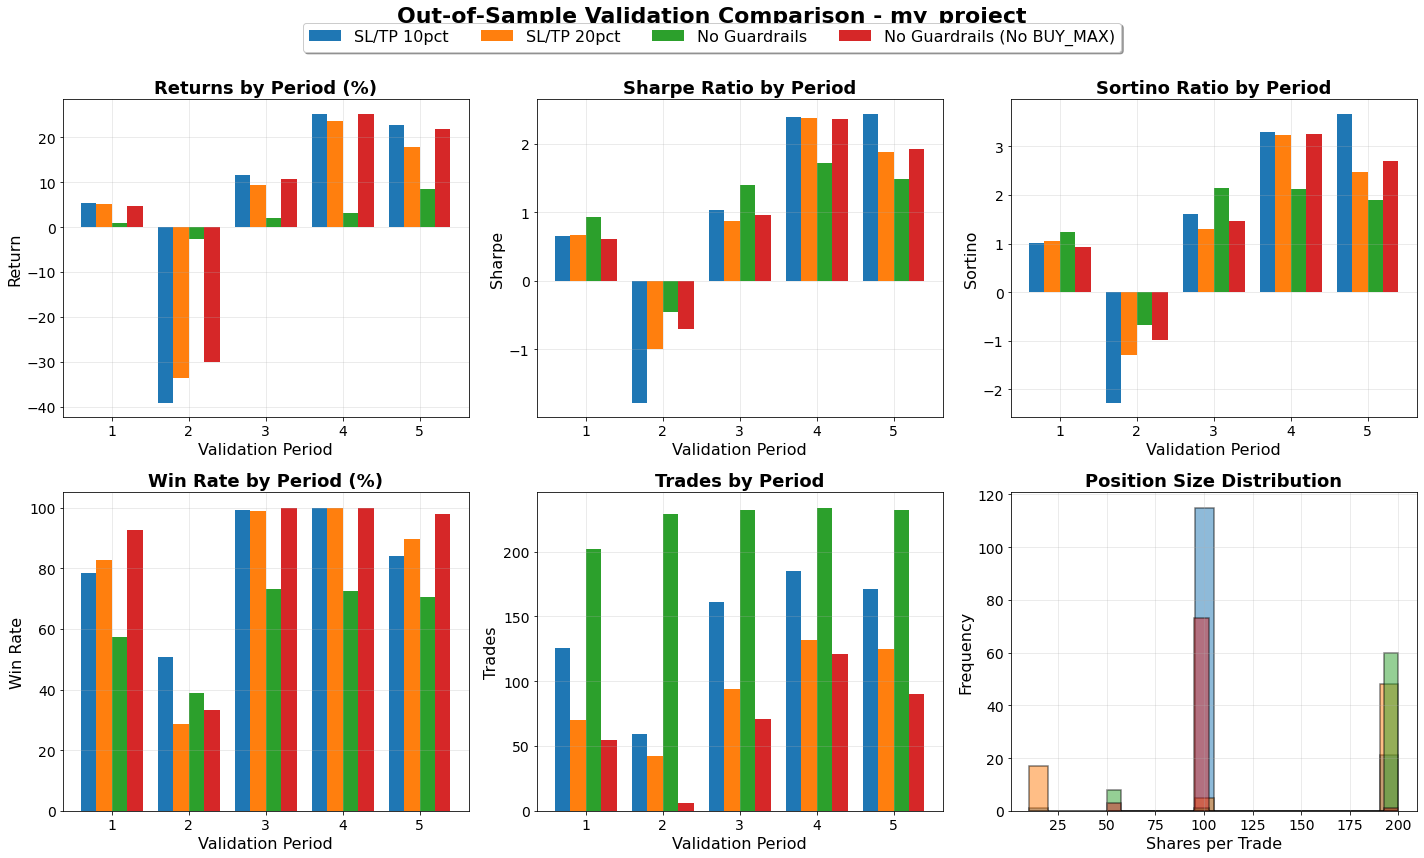

In [9]:
# Plot validation comparison
if len(validation_periods) > 0 and len(all_results) > 0:
    # Set professional plot style
    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 16,
        'axes.titlesize': 18,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'figure.titlesize': 20
    })
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.patch.set_facecolor('white')

    metrics_to_plot = [
        ('return', 'Returns by Period (%)', 0, 0, 100),
        ('sharpe', 'Sharpe Ratio by Period', 0, 1, 1),
        ('sortino', 'Sortino Ratio by Period', 0, 2, 1),
        ('win_rate', 'Win Rate by Period (%)', 1, 0, 100),
        ('trades', 'Trades by Period', 1, 1, 1)
    ]

    for metric, title, row, col, multiplier in metrics_to_plot:
        ax = axes[row, col]

        x = np.arange(1, len(validation_periods) + 1)
        width = 0.8 / max(len(all_results), 1)

        for i, (strategy_name, period_metrics) in enumerate(validation_results.items()):
            values = [pm[metric] * multiplier for pm in period_metrics]
            offset = (i - len(all_results)/2 + 0.5) * width
            ax.bar(x + offset, values, width, label=strategy_name)

        ax.set_title(title, fontsize=18, fontweight='bold')
        ax.set_xlabel('Validation Period', fontsize=16)
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=16)
        ax.set_xticks(x)
        ax.tick_params(axis='both', labelsize=14)
        ax.grid(True, alpha=0.3)

    # Position Size Distribution
    ax = axes[1, 2]
    for strategy_name, position_sizes in validation_position_distributions.items():
        if position_sizes:
            ax.hist(position_sizes, bins=20, alpha=0.5, label=strategy_name, edgecolor='black', linewidth=1.5)
    ax.set_title('Position Size Distribution', fontsize=18, fontweight='bold')
    ax.set_xlabel('Shares per Trade', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True, alpha=0.3)

    # Single legend for entire figure
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.985), 
               ncol=len(all_results), fontsize=16, frameon=True, fancybox=True, shadow=True)

    plt.suptitle(f'Out-of-Sample Validation Comparison - {PROJECT_FOLDER}', fontsize=22, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save the plot
    plot_path = f"{results_dir}/validation_comparison.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"✅ Validation comparison plot saved to: {plot_path}")
    
    plt.show()
    
    # Reset to default
    plt.rcParams.update(plt.rcParamsDefault)
else:
    print("📊 No validation periods to plot")

## 7. Test Set Comparison

Compare all strategies on the held-out test period.

In [10]:
# Test all strategies
print(f"\n{'='*70}")
print(f"🧪 FINAL TEST COMPARISON")
print(f"{'='*70}")
print(f"Test period: {test_data.index.min().date()} to {test_data.index.max().date()}")
print(f"Test samples: {len(test_data)}\n")

test_results = {}
test_position_distributions = {}
metrics_calc = PerformanceMetrics()

for strategy_name, results in all_results.items():
    print(f"Testing: {strategy_name}")
    trainer = results['trainer']

    test_env = TradingEnvironment(
        test_data,
        feature_columns,
        results['config'],
        mode='test'
    )

    test_metrics = trainer.evaluate(test_env, verbose=False)
    comprehensive_metrics = metrics_calc.calculate_metrics(
        test_env.portfolio_values,
        test_env.trades,
        test_env.starting_balance
    )
    
    # Collect position sizes from buy trades
    position_sizes = []
    for trade in test_env.trades:
        if trade['action'] == 'BUY':
            position_sizes.append(trade['shares'])

    test_results[strategy_name] = {
        'metrics': comprehensive_metrics,
        'portfolio_values': test_env.portfolio_values.copy(),
        'trades': test_env.trades.copy()
    }
    
    test_position_distributions[strategy_name] = position_sizes

    print(f"  Return: {comprehensive_metrics['total_return']:.2%}")
    print(f"  Sharpe: {comprehensive_metrics['sharpe_ratio']:.2f}")
    print(f"  Win Rate: {comprehensive_metrics['win_rate']:.2%}\n")

print(f"✅ Test evaluation complete for all strategies")


🧪 FINAL TEST COMPARISON
Test period: 2024-12-30 to 2025-12-30
Test samples: 251

Testing: SL/TP 10pct
Guardrail Triggered at step 64: Stop Loss triggered (-10.55% loss)
Guardrail Triggered at step 83: Take Profit triggered (10.53% gain)
  Return: 15.16%
  Sharpe: 1.63
  Win Rate: 82.98%

Testing: SL/TP 20pct
  Return: 5.27%
  Sharpe: 1.63
  Win Rate: 71.43%

Testing: No Guardrails
  Return: 6.70%
  Sharpe: 0.56
  Win Rate: 69.20%

Testing: No Guardrails (No BUY_MAX)
  Return: 11.42%
  Sharpe: 1.11
  Win Rate: 94.29%

✅ Test evaluation complete for all strategies


In [11]:
# Test comparison table
comparison_data = []
for strategy_name, result in test_results.items():
    m = result['metrics']
    comparison_data.append({
        'Strategy': strategy_name,
        'Return (%)': f"{m['total_return']*100:.2f}",
        'Sharpe': f"{m['sharpe_ratio']:.2f}",
        'Sortino': f"{m['sortino_ratio']:.2f}",
        'Max DD (%)': f"{m['max_drawdown']*100:.2f}",
        'Win Rate (%)': f"{m['win_rate']*100:.2f}",
        'Trades': m['num_trades']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("📊 TEST RESULTS SUMMARY")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


📊 TEST RESULTS SUMMARY
                  Strategy Return (%) Sharpe Sortino Max DD (%) Win Rate (%)  Trades
               SL/TP 10pct      15.16   1.63    2.32      -6.80        82.98     141
               SL/TP 20pct       5.27   1.63    2.36      -1.57        71.43      42
             No Guardrails       6.70   0.56    0.60     -14.31        69.20     224
No Guardrails (No BUY_MAX)      11.42   1.11    1.43      -9.99        94.29      70


✅ Test portfolio comparison saved to: results/my_project/run_20260121_065600/test_portfolio_values.png


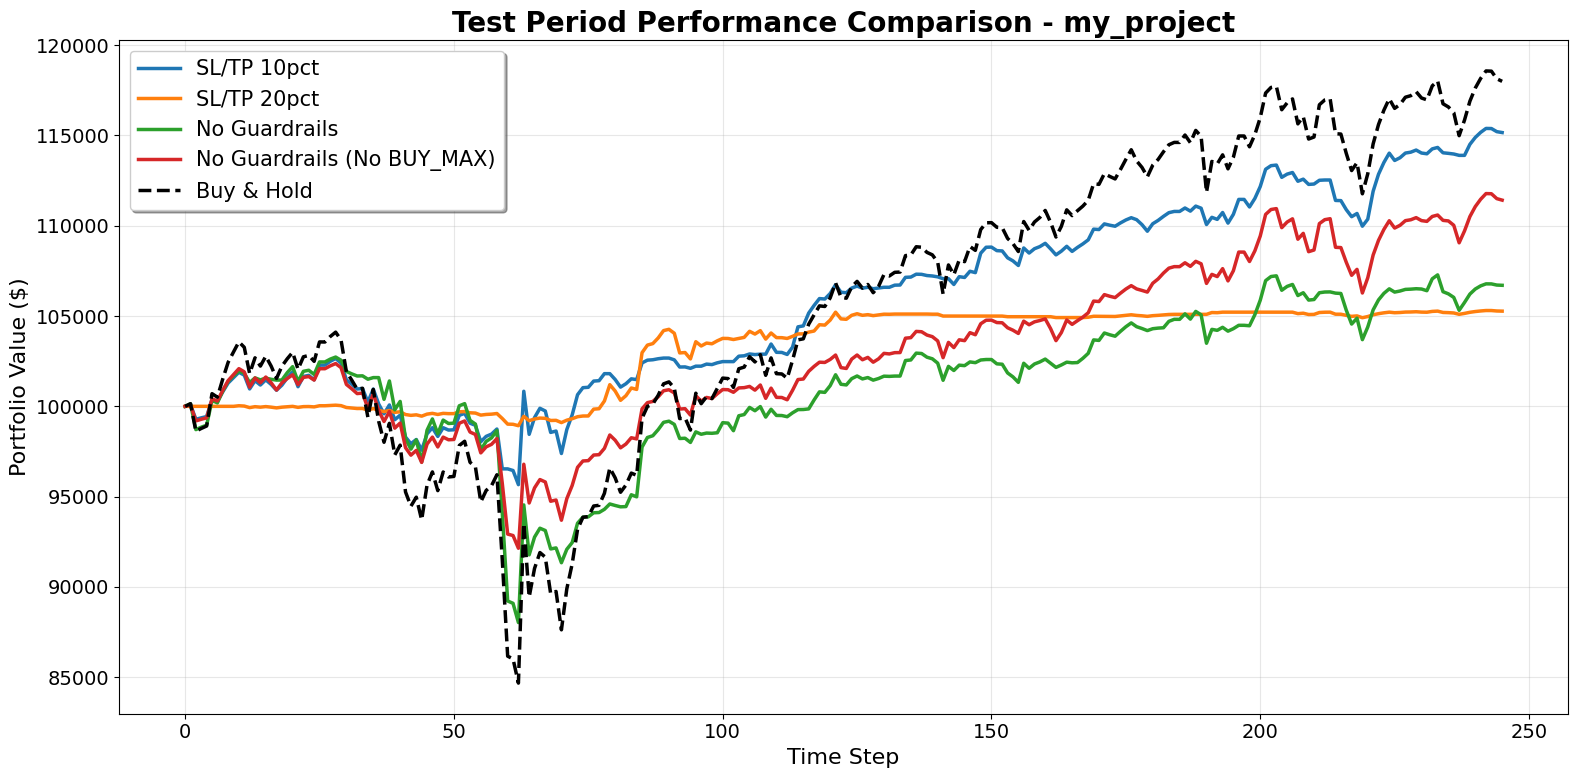

In [12]:
# Plot test comparison - Portfolio values over time
# Set professional plot style
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 15,
    'figure.titlesize': 20
})

fig, ax = plt.subplots(figsize=(16, 8))
fig.patch.set_facecolor('white')

for strategy_name, result in test_results.items():
    ax.plot(result['portfolio_values'], label=strategy_name, linewidth=2.5)

# Add buy & hold - FIXED: Buy max shares at start, track stock value + remaining cash
price_col = f"{ticker}_Close_orig"
window_size = data_config.config['data']['window_size']
starting_balance = list(all_results.values())[0]['config']['trading']['starting_balance']

# Get initial price and buy max whole shares
initial_price = test_data.iloc[window_size][price_col]
shares_bought = int(starting_balance / initial_price)  # Whole shares only
cash_remaining = starting_balance - (shares_bought * initial_price)

# Calculate portfolio value at each step = (shares * price) + cash
buy_hold_values = []
for i in range(len(test_results[list(test_results.keys())[0]]['portfolio_values'])):
    current_price = test_data.iloc[window_size + i][price_col]
    portfolio_value = (shares_bought * current_price) + cash_remaining
    buy_hold_values.append(portfolio_value)

# Calculate buy & hold return for comparison
buy_hold_return = (buy_hold_values[-1] - starting_balance) / starting_balance

ax.plot(buy_hold_values, label='Buy & Hold', linewidth=2.5, linestyle='--', color='black')

ax.set_title(f'Test Period Performance Comparison - {PROJECT_FOLDER}', fontsize=20, fontweight='bold')
ax.set_xlabel('Time Step', fontsize=16)
ax.set_ylabel('Portfolio Value ($)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
ax.legend(loc='best', fontsize=15, frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save the plot
plot_path = f"{results_dir}/test_portfolio_values.png"
plt.savefig(plot_path, dpi=150, bbox_inches='tight', facecolor='white', edgecolor='none')
print(f"✅ Test portfolio comparison saved to: {plot_path}")

plt.show()

# Reset to default
plt.rcParams.update(plt.rcParamsDefault)

✅ Test metrics comparison saved to: results/my_project/run_20260121_065600/test_metrics_comparison.png


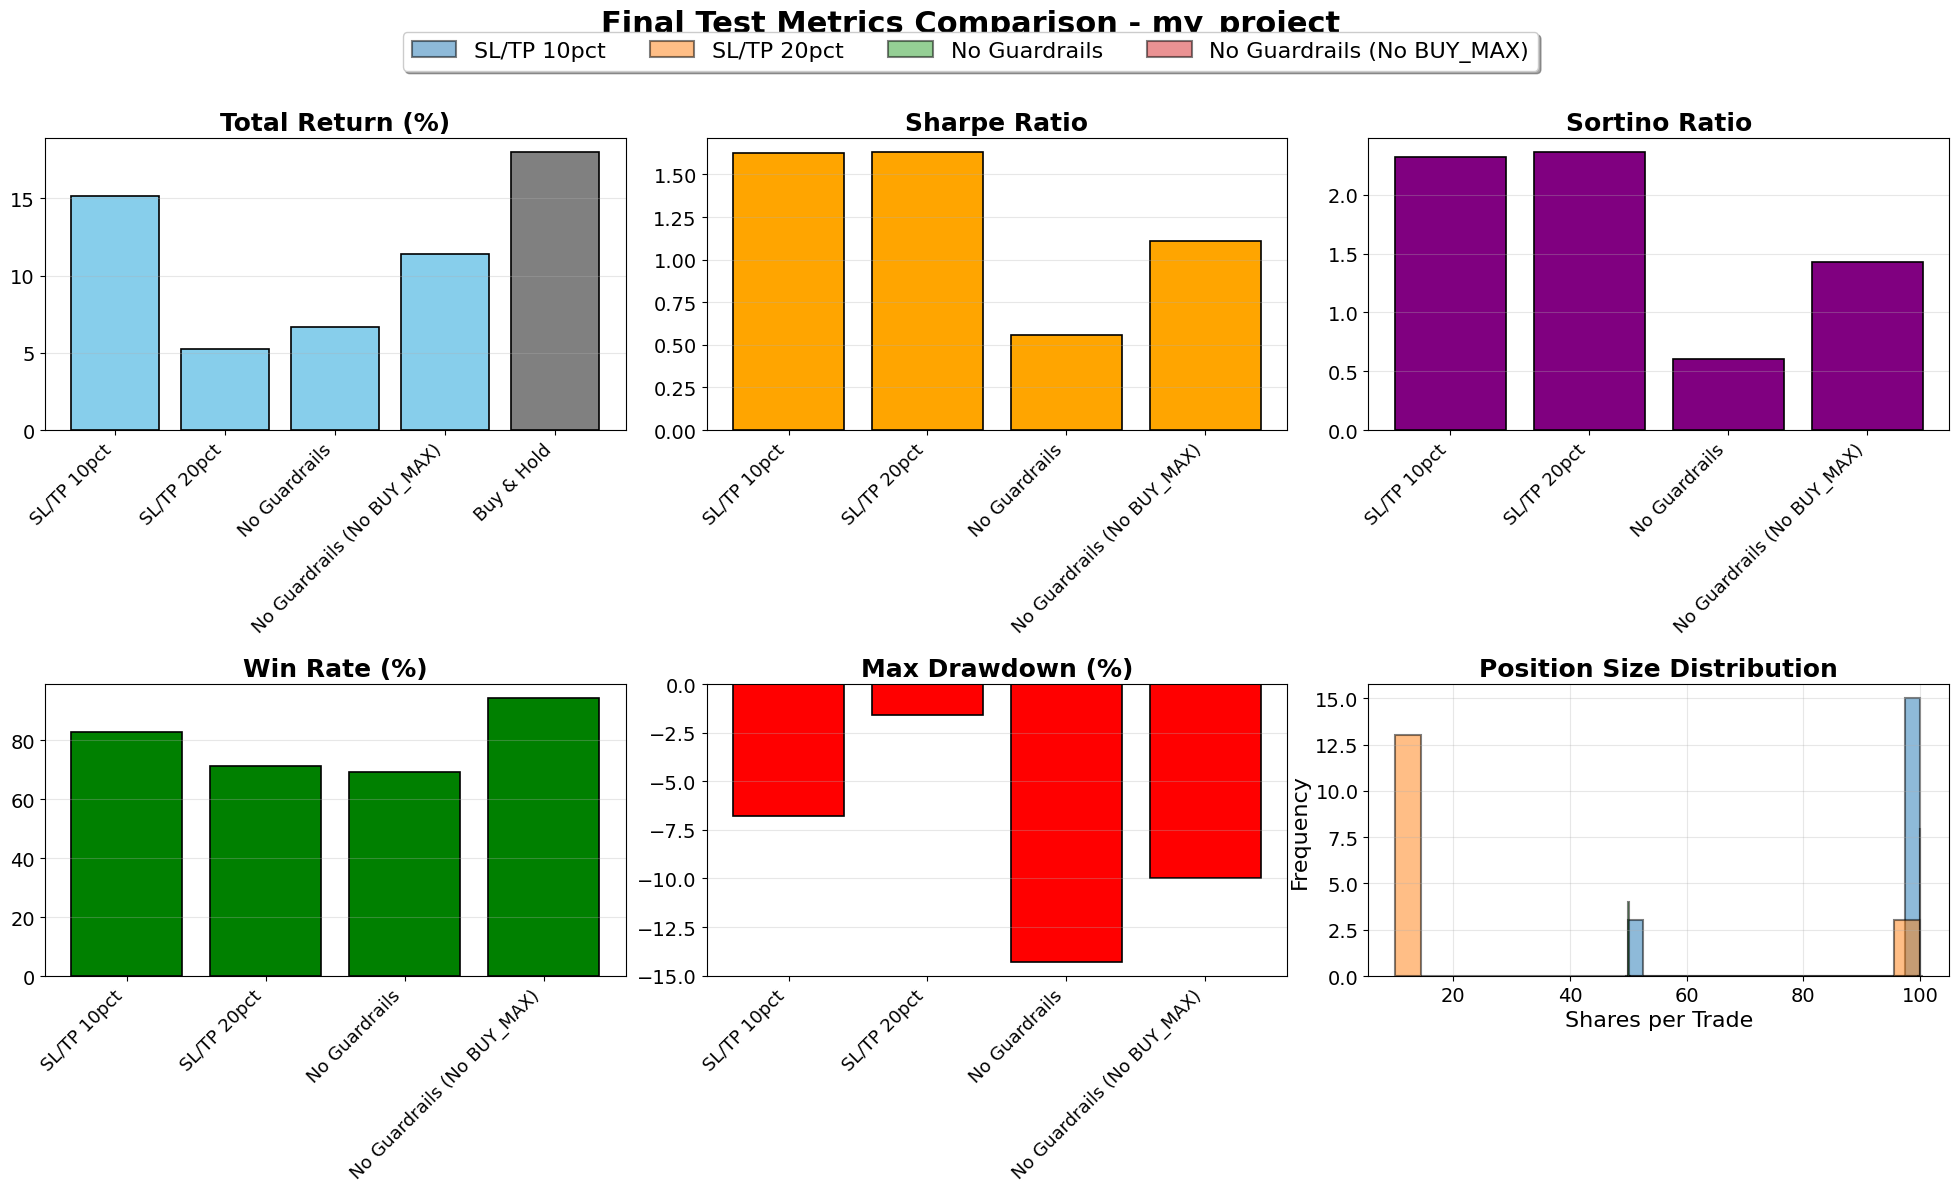

In [13]:
# Final comparison bar chart
# Set professional plot style
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 13,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20
})

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.patch.set_facecolor('white')

strategies = list(test_results.keys())
returns = [test_results[s]['metrics']['total_return'] * 100 for s in strategies]
sharpes = [test_results[s]['metrics']['sharpe_ratio'] for s in strategies]
sortinos = [test_results[s]['metrics']['sortino_ratio'] for s in strategies]
win_rates = [test_results[s]['metrics']['win_rate'] * 100 for s in strategies]
max_drawdowns = [test_results[s]['metrics']['max_drawdown'] * 100 for s in strategies]

# Add buy & hold to comparison
strategies_with_bh = strategies + ['Buy & Hold']
returns_with_bh = returns + [buy_hold_return * 100]

x = np.arange(len(strategies))
x_with_bh = np.arange(len(strategies_with_bh))

# Row 1: Returns, Sharpe, Sortino
axes[0, 0].bar(x_with_bh, returns_with_bh, color=['skyblue']*len(strategies) + ['gray'], edgecolor='black', linewidth=1.2)
axes[0, 0].set_title('Total Return (%)', fontsize=18, fontweight='bold')
axes[0, 0].set_xticks(x_with_bh)
axes[0, 0].set_xticklabels(strategies_with_bh, rotation=45, ha='right', fontsize=13)
axes[0, 0].tick_params(axis='y', labelsize=14)
axes[0, 0].grid(True, alpha=0.3, axis='y')

axes[0, 1].bar(x, sharpes, color='orange', edgecolor='black', linewidth=1.2)
axes[0, 1].set_title('Sharpe Ratio', fontsize=18, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(strategies, rotation=45, ha='right', fontsize=13)
axes[0, 1].tick_params(axis='y', labelsize=14)
axes[0, 1].grid(True, alpha=0.3, axis='y')

axes[0, 2].bar(x, sortinos, color='purple', edgecolor='black', linewidth=1.2)
axes[0, 2].set_title('Sortino Ratio', fontsize=18, fontweight='bold')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(strategies, rotation=45, ha='right', fontsize=13)
axes[0, 2].tick_params(axis='y', labelsize=14)
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Row 2: Win Rate, Max Drawdown, Position Size Distribution
axes[1, 0].bar(x, win_rates, color='green', edgecolor='black', linewidth=1.2)
axes[1, 0].set_title('Win Rate (%)', fontsize=18, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(strategies, rotation=45, ha='right', fontsize=13)
axes[1, 0].tick_params(axis='y', labelsize=14)
axes[1, 0].grid(True, alpha=0.3, axis='y')

axes[1, 1].bar(x, max_drawdowns, color='red', edgecolor='black', linewidth=1.2)
axes[1, 1].set_title('Max Drawdown (%)', fontsize=18, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(strategies, rotation=45, ha='right', fontsize=13)
axes[1, 1].tick_params(axis='y', labelsize=14)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Position Size Distribution
for strategy_name, position_sizes in test_position_distributions.items():
    if position_sizes:
        axes[1, 2].hist(position_sizes, bins=20, alpha=0.5, label=strategy_name, edgecolor='black', linewidth=1.5)
axes[1, 2].set_title('Position Size Distribution', fontsize=18, fontweight='bold')
axes[1, 2].set_xlabel('Shares per Trade', fontsize=16)
axes[1, 2].set_ylabel('Frequency', fontsize=16)
axes[1, 2].tick_params(axis='both', labelsize=14)
axes[1, 2].grid(True, alpha=0.3)

# Single legend for entire figure
handles, labels = axes[1, 2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.985), 
           ncol=len(strategies), fontsize=16, frameon=True, fancybox=True, shadow=True)

plt.suptitle(f'Final Test Metrics Comparison - {PROJECT_FOLDER}', fontsize=22, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Save the plot
plot_path = f"{results_dir}/test_metrics_comparison.png"
plt.savefig(plot_path, dpi=150, bbox_inches='tight', facecolor='white', edgecolor='none')
print(f"✅ Test metrics comparison saved to: {plot_path}")

plt.show()

# Reset to default
plt.rcParams.update(plt.rcParamsDefault)

## 8. Save Final Results

In [ ]:
# Save final results data (plots already saved above)
# Note: results_dir was created in cell 3

# Save CSV comparison
comparison_df.to_csv(f"{results_dir}/test_comparison.csv", index=False)

# Save comprehensive results
final_results = {
    'timestamp': datetime.now().isoformat(),
    'project': PROJECT_FOLDER,
    'test_mode': TEST_MODE,
    'run_name': run_name,
    'data_config': data_config.config,
    'strategies': {},
    'validation_results': validation_results,
    'validation_position_distributions': validation_position_distributions,
    'test_results': {k: v['metrics'] for k, v in test_results.items()},
    'test_position_distributions': test_position_distributions,
    'buy_hold_return': float(buy_hold_return)
}

for strategy_name, results in all_results.items():
    final_results['strategies'][strategy_name] = {
        'experiment_name': results['experiment_name'],
        'config': results['config'],
        'training_history': results['training_history']['training_history']
    }

# Save to JSON
results_path = f"{results_dir}/final_results.json"
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"\n{'='*70}")
print(f"✅ COMPLETE PIPELINE FINISHED!")
print(f"{'='*70}")
print(f"📁 Project: {PROJECT_FOLDER}")
print(f"📝 Run name: {run_name}")
print(f"📊 Strategies trained: {len(trading_configs)}")
print(f"📈 Results saved to: {results_dir}/")
print(f"📄 Final results: {results_path}")

# List saved files
saved_files = os.listdir(results_dir)
saved_files.sort()
print(f"\n📁 Saved files:")
for file in saved_files:
    size_kb = os.path.getsize(f"{results_dir}/{file}") / 1024
    file_type = "📊 Plot" if file.endswith('.png') else "📄 Data" if file.endswith('.csv') else "📋 Results"
    print(f"   {file_type}: {file} ({size_kb:.1f} KB)")

# Count plots saved
plot_files = [f for f in saved_files if f.endswith('.png')]
print(f"\n📊 Plots saved: {len(plot_files)}")

# Show best strategy
if test_results:
    print(f"\n🏆 Best performing strategy:")
    best_strategy = max(test_results.items(), key=lambda x: x[1]['metrics']['total_return'])
    print(f"   {best_strategy[0]}")
    print(f"   • Return: {best_strategy[1]['metrics']['total_return']:.2%}")
    print(f"   • Sharpe: {best_strategy[1]['metrics']['sharpe_ratio']:.2f}")
    print(f"   • vs Buy & Hold: {(best_strategy[1]['metrics']['total_return'] - buy_hold_return):.2%}")

print(f"{'='*70}")

# Print final summary
logger.print_summary()